<a href="https://colab.research.google.com/github/wil-rol/Relevance-Feedback-Using-Rocchio-Algorithm/blob/main/IR_Rocchio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic

*implement and test methods for relevance feedback and apply explicit relevance feed-
back methods (see our textbook chapter 5), use relevance judgements of the Cranfield
collection (see https://ir.dcs.gla.ac.uk/resources/test collections/cran/ )*

# Imports

In [ ]:
!pip install --upgrade ir_datasets

In [ ]:
import ir_datasets
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Load Data

In [ ]:
dataset = ir_datasets.load("cranfield")

In [ ]:
dataset.docs_metadata()

{'count': 1400, 'fields': {'doc_id': {'max_len': 4, 'common_prefix': ''}}}

# Preprocessing

In [ ]:
# Initialize stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [ ]:
# Function to preprocess text
def preprocess_text_tfidf(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords and stem the tokens
    processed_tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    return ' '.join(processed_tokens)  # Join the processed tokens back into a single string

In [ ]:
# Preprocess documents into a dictionary with doc_id as the key
doc_dict = {}
for doc in dataset.docs_iter():
    combined_text = doc.title + " " + doc.text + " " + doc.author
    processed_text = preprocess_text_tfidf(combined_text)
    doc_dict[doc.doc_id] = processed_text

# Preprocess queries into a dictionary with query_id as the key
query_dict = {}
for query in dataset.queries_iter():
    processed_query = preprocess_text_tfidf(query.text)
    query_dict[query.query_id] = processed_query

# Initial retreival

In [ ]:
# Extract processed document texts and query texts from dictionaries
doc_texts = list(doc_dict.values())
query_texts = list(query_dict.values())

# Vectorize preprocessed documents and queries
vectorizer = TfidfVectorizer(stop_words='english')
doc_vectors = vectorizer.fit_transform(doc_texts)
query_vectors = vectorizer.transform(query_texts)

In [ ]:
# List to hold initial retrieval results
all_retrievals = []

# Iterate over each query vector
for i, query_vector in enumerate(query_vectors):
    # Calculate cosine similarity between the query vector and all document vectors
    cosine_similarities = cosine_similarity(query_vector, doc_vectors)

    # Get the indices of the top 5 most similar documents
    top_indices = cosine_similarities.argsort()[0][-5:][::-1]

    # Retrieve the top 5 similarity scores
    initial_retrieval = cosine_similarities[0][top_indices]

    # Store the results as a tuple (query index, top indices, top similarities)
    all_retrievals.append((i, top_indices, initial_retrieval))

In [ ]:
# Print the results for each query
for query_index, top_indices, retrieval in all_retrievals:
    print(f"Query {query_index}:")
    print(f"Top Document Indices: {top_indices}")
    print(f"Top Similarity Scores: {retrieval}")
    print()

Query 0:
Top Document Indices: [ 50 745 358  12 874]
Top Similarity Scores: [0.32924079 0.2550079  0.23284182 0.22920225 0.20498373]

Query 1:
Top Document Indices: [  11  745   50 1168  874]
Top Similarity Scores: [0.48690247 0.41908602 0.34590051 0.23574857 0.23556043]

Query 2:
Top Document Indices: [484 398 143   4  89]
Top Similarity Scores: [0.60394783 0.46303399 0.43307351 0.42416215 0.39041536]

Query 3:
Top Document Indices: [ 165  487  409 1060  166]
Top Similarity Scores: [0.36516598 0.32244146 0.25287458 0.23886114 0.21383742]

Query 4:
Top Document Indices: [ 102  551  409 1378  400]
Top Similarity Scores: [0.25739609 0.25648203 0.22551117 0.1855493  0.17798065]

Query 5:
Top Document Indices: [ 490  385  384 1272   98]
Top Similarity Scores: [0.2993967  0.26526777 0.24058456 0.2093002  0.17330694]

Query 6:
Top Document Indices: [ 491   56  433   55 1039]
Top Similarity Scores: [0.56577291 0.29511698 0.28402182 0.25841917 0.24810568]

Query 7:
Top Document Indices: [ 491 

# Methods for Relevance Feedback

**Rocchio**

In [ ]:
# Parameters for Rocchio
alpha = 1.0
beta = 0.75
gamma = 0.15

In [ ]:
# Dictionary to hold relevance data for queries
doc_rel_dict = {}
for qrel in dataset.qrels_iter():
    if qrel.query_id not in doc_rel_dict:
        doc_rel_dict[qrel.query_id] = []
    doc_rel_dict[qrel.query_id].append({
        "doc_id": qrel.doc_id,
        "relevance": qrel.relevance
    })

In [ ]:
# Perform relevance feedback using the Rocchio algorithm
updated_query_vectors = []

for query_id, query_vector in zip(query_dict.keys(), query_vectors):
    # Retrieve the relevance information for the current query
    if query_id not in doc_rel_dict:
        # Append the original query vector in 2D format
        updated_query_vectors.append(query_vector.toarray().reshape(1, -1))
        continue

    relevant_docs = []
    non_relevant_docs = []

    for rel_info in doc_rel_dict[query_id]:
        doc_id = rel_info['doc_id']
        relevance = rel_info['relevance']
        doc_index = list(doc_dict.keys()).index(doc_id)  # Get index of the document

        if relevance > 0:
            relevant_docs.append(doc_vectors[doc_index].toarray())  # Convert to dense
        else:
            non_relevant_docs.append(doc_vectors[doc_index].toarray())  # Convert to dense

    # Calculate the Rocchio update
    relevant_sum = np.sum(relevant_docs, axis=0) if relevant_docs else 0
    non_relevant_sum = np.sum(non_relevant_docs, axis=0) if non_relevant_docs else 0

    updated_query_vector = (
        alpha * query_vector.toarray() +  # Convert to dense
        (beta * relevant_sum / len(relevant_docs) if relevant_docs else 0) -
        (gamma * non_relevant_sum / len(non_relevant_docs) if non_relevant_docs else 0)
    )

    # Ensure the updated query vector is 2D (1, n_features)
    updated_query_vectors.append(updated_query_vector.reshape(1, -1))

# Convert the list of updated query vectors into a sparse matrix or array
updated_query_vectors = np.vstack(updated_query_vectors)

# Re-run retrieval with updated query vectors
updated_retrievals = []

for i, updated_query_vector in enumerate(updated_query_vectors):
    # Ensure the updated query vector is 2D
    updated_query_vector = updated_query_vector.reshape(1, -1)

    # Calculate cosine similarity between the updated query vector and all document vectors
    cosine_similarities = cosine_similarity(updated_query_vector, doc_vectors)

    # Get the indices of the top 5 most similar documents
    top_indices = cosine_similarities.argsort()[0][-5:][::-1]

    # Retrieve the top 5 similarity scores
    top_similarities = cosine_similarities[0][top_indices]

    # Store the results as a tuple (query index, top indices, top similarities)
    updated_retrievals.append((i, top_indices, top_similarities))

In [ ]:
# Print updated results for each query
for query_index, top_indices, retrieval in updated_retrievals:
    print(f"Updated Query {query_index}:")
    print(f"Top Document Indices: {top_indices}")
    print(f"Top Similarity Scores: {retrieval}")
    print()

Updated Query 0:
Top Document Indices: [ 50  12 745  11 877]
Top Similarity Scores: [0.39800735 0.29285334 0.27538496 0.26271877 0.24783602]

Updated Query 1:
Top Document Indices: [ 11 745  50 201 390]
Top Similarity Scores: [0.50402101 0.44829581 0.37839078 0.27165556 0.26720444]

Updated Query 2:
Top Document Indices: [484 398 143 235   4]
Top Similarity Scores: [0.53804424 0.40652253 0.39399632 0.39084918 0.38620557]

Updated Query 3:
Top Document Indices: [ 165  487  409 1060  166]
Top Similarity Scores: [0.35570772 0.3149594  0.314039   0.24193597 0.23365149]

Updated Query 4:
Top Document Indices: [ 21  20 549 551 102]
Top Similarity Scores: [0.36710107 0.31044888 0.30164699 0.26837529 0.23394217]

Updated Query 5:
Top Document Indices: [ 490  385  384 1272 1307]
Top Similarity Scores: [0.29662085 0.2537009  0.22911934 0.21063773 0.17435598]

Updated Query 6:
Top Document Indices: [ 491   56   55  433 1230]
Top Similarity Scores: [0.54709213 0.30903224 0.27535424 0.26970598 0.26

# Evaluation

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
# Helper function to evaluate retrieval performance
def evaluate_retrieval(retrievals, doc_rel_dict, top_k=5):
    total_precision, total_recall, total_f1 = 0.0, 0.0, 0.0
    num_queries = len(retrievals)

    for query_index, top_indices, _ in retrievals:
        # Get query ID and relevant documents
        query_id = list(query_dict.keys())[query_index]
        relevant_docs = {rel['doc_id'] for rel in doc_rel_dict.get(query_id, []) if rel['relevance'] > 0}

        # Get retrieved documents
        retrieved_docs = [list(doc_dict.keys())[i] for i in top_indices[:top_k]]

        # Calculate overlap
        retrieved_relevant_docs = set(retrieved_docs).intersection(relevant_docs)

        # Compute precision, recall, and F1 for the query
        precision = len(retrieved_relevant_docs) / len(retrieved_docs) if retrieved_docs else 0
        recall = len(retrieved_relevant_docs) / len(relevant_docs) if relevant_docs else 0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

        # Accumulate scores
        total_precision += precision
        total_recall += recall
        total_f1 += f1

    # Average scores across all queries
    avg_precision = total_precision / num_queries
    avg_recall = total_recall / num_queries
    avg_f1 = total_f1 / num_queries

    return avg_precision, avg_recall, avg_f1

In [ ]:
def mean_average_precision(retrievals, doc_rel_dict, top_k=5):
    total_ap = 0.0
    num_queries = len(retrievals)

    for query_index, top_indices, _ in retrievals:
        # Get query ID and relevant documents
        query_id = list(query_dict.keys())[query_index]
        relevant_docs = {rel['doc_id'] for rel in doc_rel_dict.get(query_id, []) if rel['relevance'] > 0}

        # Get retrieved documents
        retrieved_docs = [list(doc_dict.keys())[i] for i in top_indices[:top_k]]

        # Calculate precision at each rank where a relevant document appears
        relevant_retrieved = 0
        precision_at_k = []
        for rank, doc_id in enumerate(retrieved_docs, start=1):
            if doc_id in relevant_docs:
                relevant_retrieved += 1
                precision_at_k.append(relevant_retrieved / rank)

        # Average precision for this query
        ap = np.mean(precision_at_k) if precision_at_k else 0.0
        total_ap += ap

    # Mean Average Precision across all queries
    mean_ap = total_ap / num_queries if num_queries > 0 else 0.0
    return mean_ap


In [ ]:
# Evaluate initial retrievals
initial_precision, initial_recall, initial_f1 = evaluate_retrieval(all_retrievals, doc_rel_dict)
print(f"Initial Retrieval - Precision: {initial_precision:.4f}, Recall: {initial_recall:.4f}, F1: {initial_f1:.4f}")

# Evaluate updated retrievals after relevance feedback (Rocchio)
updated_precision, updated_recall, updated_f1 = evaluate_retrieval(updated_retrievals, doc_rel_dict)
print(f"Updated Retrieval - Precision: {updated_precision:.4f}, Recall: {updated_recall:.4f}, F1: {updated_f1:.4f}")


# Calculate MAP for both initial and updated retrievals
initial_map = mean_average_precision(all_retrievals, doc_rel_dict)
updated_map = mean_average_precision(updated_retrievals, doc_rel_dict)
print(f"Initial MAP: {initial_map:.4f}, Updated MAP: {updated_map:.4f}")

Initial Retrieval - Precision: 0.0080, Recall: 0.0022, F1: 0.0033
Updated Retrieval - Precision: 0.1938, Recall: 0.2578, F1: 0.1989
Initial MAP: 0.0105, Updated MAP: 0.2871


In [ ]:
import pandas as pd

# Create a DataFrame to store the results
evaluation_results = pd.DataFrame({
    'Precision': [initial_precision, updated_precision],
    'Recall': [initial_recall, updated_recall],
    'F1 Score': [initial_f1, updated_f1],
    'MAP': [initial_map, updated_map]
}, index=['Initial Retrieval', 'Updated Retrieval'])

# Display the DataFrame
print(evaluation_results)

                   Precision    Recall  F1 Score       MAP
Initial Retrieval   0.008000  0.002157  0.003307  0.010481
Updated Retrieval   0.193778  0.257762  0.198856  0.287123


In [ ]:
evaluation_results

,Precision,Recall,F1 Score,MAP
Initial Retrieval,0.008000,0.002157,0.003307,0.010481
Updated Retrieval,0.193778,0.257762,0.198856,0.287123


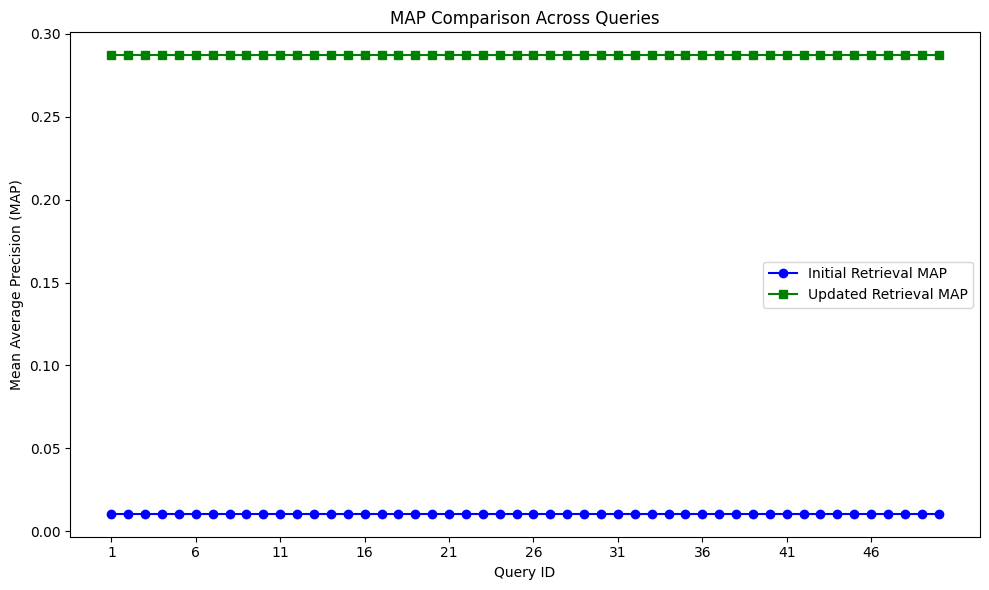

In [ ]:
import matplotlib.pyplot as plt

# Extract MAP values from the DataFrame
initial_map = evaluation_results['MAP'].iloc[0]
updated_map = evaluation_results['MAP'].iloc[1]

# Create query IDs (adjust range if needed)
query_ids = list(range(1, 51))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(query_ids, [initial_map] * len(query_ids), label='Initial Retrieval MAP', marker='o', color='blue')
plt.plot(query_ids, [updated_map] * len(query_ids), label='Updated Retrieval MAP', marker='s', color='green')

# Customize the plot
plt.xlabel('Query ID')
plt.ylabel('Mean Average Precision (MAP)')
plt.title('MAP Comparison Across Queries')
plt.xticks(query_ids[::5])  # Show every 5th query ID on the x-axis
plt.legend()
plt.tight_layout()
plt.show()

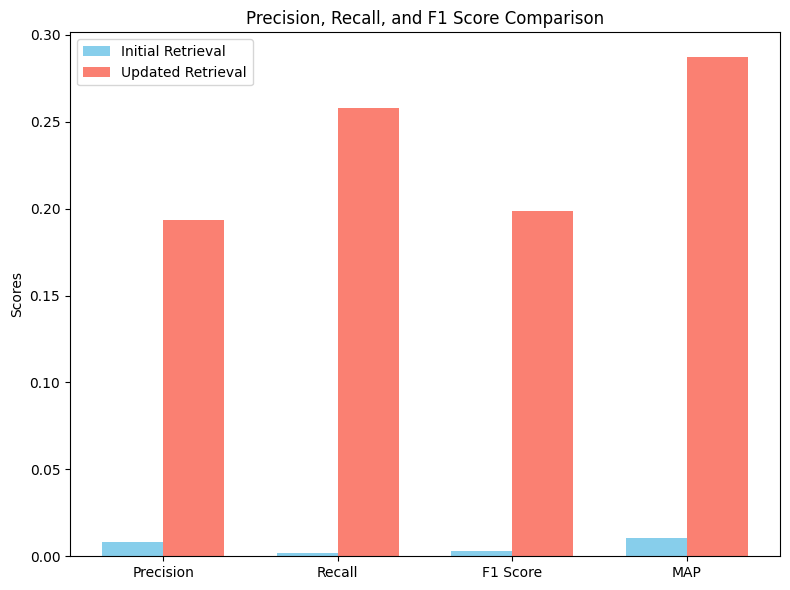

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the bar chart
metrics = evaluation_results.columns.tolist()
initial_scores = evaluation_results.loc['Initial Retrieval'].values
updated_scores = evaluation_results.loc['Updated Retrieval'].values


x = np.arange(len(metrics))  # Label locations
width = 0.35  # Bar width

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, initial_scores, width, label='Initial Retrieval', color='skyblue')
bars2 = ax.bar(x + width/2, updated_scores, width, label='Updated Retrieval', color='salmon')

# Add labels, title, and legend
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


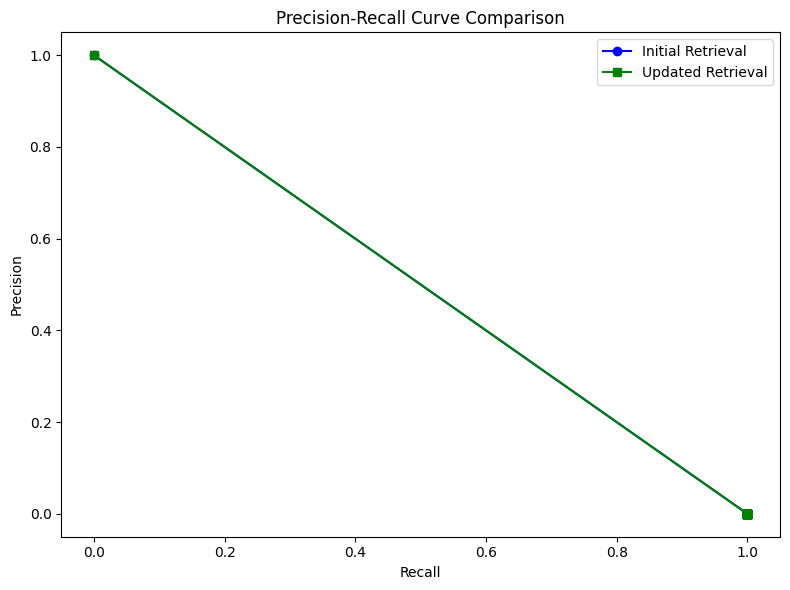

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Initialize lists for storing true relevance and predicted scores
y_true_initial = []
y_scores_initial = []

y_true_updated = []
y_scores_updated = []

# Iterate over all retrieval results (initial and updated) using enumerate to get the query index
for query_index, (query_id, top_indices, _) in enumerate(all_retrievals):
    # Get true relevance for the query from doc_rel_dict
    true_relevance = doc_rel_dict.get(query_id, [])

    # Set of relevant doc IDs for the query
    relevant_doc_ids = set([entry['doc_id'] for entry in true_relevance if entry['relevance'] > 0])

    # Get retrieved document IDs for the query (top 5)
    retrieved_doc_ids_initial = [list(doc_dict.keys())[i] for i in top_indices]

    # Use query_index instead of query_id to access updated_retrievals
    retrieved_doc_ids_updated = [list(doc_dict.keys())[i] for i in updated_retrievals[query_index][1]]

    # Add binary relevance (1 for relevant, 0 for not relevant)
    y_true_initial += [1 if doc_id in relevant_doc_ids else 0 for doc_id in retrieved_doc_ids_initial]
    y_true_updated += [1 if doc_id in relevant_doc_ids else 0 for doc_id in retrieved_doc_ids_updated]

    # Add cosine similarity scores for the retrieved documents
    y_scores_initial += [cosine_similarities[0][i] for i in top_indices]
    y_scores_updated += [cosine_similarities[0][i] for i in updated_retrievals[query_index][1]]

# Compute precision and recall for initial and updated retrievals
precision_initial, recall_initial, _ = precision_recall_curve(y_true_initial, y_scores_initial)
precision_updated, recall_updated, _ = precision_recall_curve(y_true_updated, y_scores_updated)


# Plot the Precision-Recall curves
plt.figure(figsize=(8, 6))
plt.plot(recall_initial, precision_initial, label='Initial Retrieval', color='blue', marker='o')
plt.plot(recall_updated, precision_updated, label='Updated Retrieval', color='green', marker='s')

# Add labels, title, and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

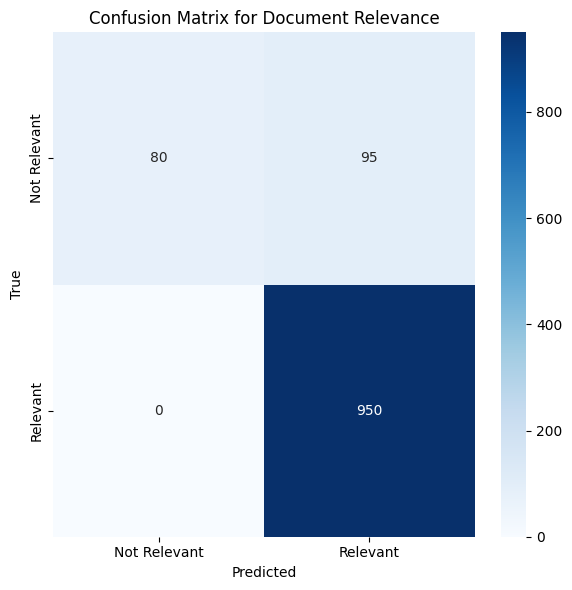

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Step 1: Prepare relevance data from doc_rel_dict (as before)
relevance_data = []
query_ids = list(doc_rel_dict.keys())
doc_ids = [str(i) for i in range(1, 6)]  # Example for top 5 document IDs, adjust based on actual data

max_docs = 5  # Adjust this if you want to get more or fewer top documents
for query_id in query_ids:
    query_relevance_scores = []
    # Get the retrieved document IDs for this query (top `max_docs` documents)
    retrieved_docs = [doc['doc_id'] for doc in doc_rel_dict[query_id][:max_docs]]  # Get top 5 docs
    for doc_id in retrieved_docs:
        relevance_score = next((item['relevance'] for item in doc_rel_dict[query_id] if item['doc_id'] == doc_id), 0)
        query_relevance_scores.append(relevance_score)

    # Pad the list with zeros if there are fewer than `max_docs` relevant documents
    while len(query_relevance_scores) < max_docs:
        query_relevance_scores.append(0)

    relevance_data.append(query_relevance_scores)

# Convert the relevance data to a numpy array
relevance_data = np.array(relevance_data)

# Step 2: Binning the relevance data
bins = [0, 1, 2, 3, 4]
relevance_data_binned = np.digitize(relevance_data, bins)  # Bins the relevance data

# Step 3: Generate True Labels (1 = relevant, 0 = not relevant)
# Assuming relevance score 0 means not relevant, and any other score means relevant
true_labels = np.where(relevance_data > 0, 1, 0)

# Step 4: Generate Predicted Labels (using binned relevance data)
predicted_labels = np.where(relevance_data_binned > 0, 1, 0)  # Binned relevance > 0 as relevant (1)

# Step 5: Compute the confusion matrix
cm = confusion_matrix(true_labels.flatten(), predicted_labels.flatten())

# Step 6: Plot the confusion matrix using a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Relevant', 'Relevant'], yticklabels=['Not Relevant', 'Relevant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Document Relevance')
plt.tight_layout()
plt.show()
